In [3]:
import pyodbc
import pandas as pd
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
from sklearn.feature_extraction.text import CountVectorizer
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
import pickle

df = pd.read_csv('./results4.csv')
df.columns = ['id', 'text', 'modText', 'sentiment', 'topics', 'hashtags']

negatives = ['not', 'no', 'nor', "won't", "wouldn't", "shouldn't", "couldn't", 'against', "aren't", "haven't", "hasn't", "doesn't", "isn't", "don't"]

#tokenize text and lowercase
df['tokText'] = df['text'].apply(lambda x: x.split())
df['tokText'] = df['tokText'].apply(lambda x: [y.lower() for y in x])

for i in range(0, len(df)):
    df['topics'][i] = df['topics'][i].replace("'',", "")
df['topics'] = df['topics'].apply(lambda x: x[1:-1].split(', '))

selectedIndex = []
#if text has 2 or more negative words, add index to selectedIndex
for i in range(0, len(df)):
    count = 0
    for word in df['tokText'][i]:
        if word in negatives:
            count += 1
    if count >= 2:
        selectedIndex.append(i)

C:\Users\andre\AppData\Local\Temp\ipykernel_17648\1786680353.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topics'][i] = df['topics'][i].replace("'',", "")


In [2]:
from gensim.similarities import SparseTermSimilarityMatrix, WordEmbeddingSimilarityIndex
import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.models import KeyedVectors
from gensim.models import TfidfModel
from gensim.similarities import SoftCosineSimilarity

userDF = pd.DataFrame(columns=['id', 'topics',])
userDF.id = df.id.unique()
#add all unique topics to userDF by id unless it is empty
for i in range(0, len(userDF)):
    userDF['topics'][i] = df[df['id'] == userDF['id'][i]]['topics'].sum()
    userDF['topics'][i] = [x for x in userDF['topics'][i] if x != "\'\'"]
    
userDF['topicsRaw'] = userDF['topics'].copy()

#change sentiment 4 to 1
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 4 else x)

#for each topic add sentiment based on mean of sentiment of the user's tweets with that topic
for i in range(0, len(userDF)):
    new_row = []

    for j in range(0, len(userDF['topics'][i])):
        new_row.append(userDF['topics'][i][j] + str((df[(df['id'] == userDF['id'][i]) & (df['topics'].apply(lambda x: userDF['topics'][i][j] in x))]['sentiment'].mean()).round(2)))
        
    userDF.at[i, 'topics'] = new_row

#convert array of topicsRaw to string
userDF['topicsRaw'] = userDF['topicsRaw'].apply(lambda x: str(x))

#clean topicsRaw and convert to array
userDF['topicsRaw'] = userDF['topicsRaw'].apply(lambda x: x.replace("\"", ""))
userDF['topicsRaw'] = userDF['topicsRaw'].apply(lambda x: x[1:-1].split(', '))

#using soft cosine similarity return 10 most similar users to a given user
fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')
documents = userDF['topics']
dictionary = Dictionary(documents)
bow_corpus = [dictionary.doc2bow(doc) for doc in documents]
index = WordEmbeddingSimilarityIndex(fasttext_model300)
sims = SparseTermSimilarityMatrix(index, dictionary)
model = SoftCosineSimilarity(bow_corpus, sims, num_best=10)

def get_recommendations(id):
    idx = userDF.index[userDF['id'] == id][0]
    query = userDF['topics'][idx]
    query = dictionary.doc2bow(query)
    return model[query]

dfCopy = df.copy()
userDfCopy = userDF.copy()

predResults = []

for i in range(0, len(selectedIndex)):
    
    df = dfCopy.copy()
    userDfCopy = userDF.copy()
    
    #get closest users to the given user to predict sentiment towards a topic
    results = get_recommendations(df['id'][selectedIndex[i]])

    #only use users with a distance of less than 0.3
    results = [x for x in results if x[1] < 0.3 ]

    #assign user{number} to each user
    userDF['user'] = ["user" + str(i) for i in range(0, len(userDF))]
    userDF['userNum'] = [str(i) for i in range(0, len(userDF))]

    print("Closest users to", userDF.loc[userDF['id'] == df['id'][selectedIndex[i]], 'user'].iloc[0], "are:", [userDF['user'][x[0]] for x in results], "with distances of:", [x[1] for x in results])

    #predict sentiment towards the chosen text based on the closest users' sentiment towards the topic
    topics = df['topics'][selectedIndex[i]]

    #find texts from close users with at least 1 topic in common with the chosen text and add to df
    closeDF = pd.DataFrame(columns=['id', 'text', 'modText', 'sentiment', 'topics', 'hashtags'])
    for i in range(0, len(results)):
        closeDF = closeDF.append(df[(df['id'] == userDF['id'][results[i][0]]) & (df['topics'].apply(lambda x: any(item in x for item in topics)))])

    #perform knn on the close users' sentiment towards the topic
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.feature_extraction.text import CountVectorizer

    closeDF = closeDF.append(pd.Series(), ignore_index=True)
    chosenTopics = df['topics'][selectedIndex[i]]
    closeDF['topics'].iloc[-1] = chosenTopics

    closeDF['topics'] = closeDF['topics'].astype(str)
    closeDF['topics'] = closeDF['topics'].astype(pd.StringDtype())
    for i in range(0, len(closeDF)):
        closeDF['topics'].iloc[i] = closeDF['topics'].iloc[i].replace("'", "")
        closeDF['topics'].iloc[i] = closeDF['topics'].iloc[i].replace(",", "")
        closeDF['topics'].iloc[i] = closeDF['topics'].iloc[i].replace("[", "")
        closeDF['topics'].iloc[i] = closeDF['topics'].iloc[i].replace("]", "")
        closeDF['topics'].iloc[i] = closeDF['topics'].iloc[i].replace("\"", "")

    #encode topics as bag of words
    try:
        vectorizer = CountVectorizer(max_features=100, stop_words='english')
        X = vectorizer.fit_transform(closeDF['topics'].astype(str))
        X = pd.DataFrame(X.todense())

        #train knn
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X[:-1].astype(int), closeDF['sentiment'][:-1].astype(int))

        #predict sentiment towards the chosen text
        closeDF['sentiment'].iloc[-1] = knn.predict(X[-1:])
        
        predResults.append(closeDF['sentiment'].iloc[-1])
    except:
        predResults.append(9)

KeyboardInterrupt: 

In [4]:
#split df into train and test. test on same percentage as the number of selected texts. 

testSize = len(selectedIndex)/len(df)

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=100, random_state=42)

train = train.append(pd.Series(), ignore_index=True)
train['sentiment'].iloc[-1] = predResults

#train knn on the dataset

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer

train['topics'] = train['topics'].astype(str)
train['topics'] = train['topics'].astype(pd.StringDtype())
for i in range(0, len(train)):
    train['topics'].iloc[i] = train['topics'].iloc[i].replace("'", "")
    train['topics'].iloc[i] = train['topics'].iloc[i].replace(",", "")
    train['topics'].iloc[i] = train['topics'].iloc[i].replace("[", "")
    train['topics'].iloc[i] = train['topics'].iloc[i].replace("]", "")
    train['topics'].iloc[i] = train['topics'].iloc[i].replace("\"", "")
    
vectorizer = CountVectorizer(max_features=100, stop_words='english')
X = vectorizer.fit_transform(train['topics'].astype(str))
X = pd.DataFrame(X.todense())

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X[:-1].astype(int), train['sentiment'][:-1].astype(int))

#predict sentiment towards the test texts
test['topics'] = test['topics'].astype(str)
test['topics'] = test['topics'].astype(pd.StringDtype())
for i in range(0, len(test)):
    test['topics'].iloc[i] = test['topics'].iloc[i].replace("'", "")
    test['topics'].iloc[i] = test['topics'].iloc[i].replace(",", "")
    test['topics'].iloc[i] = test['topics'].iloc[i].replace("[", "")
    test['topics'].iloc[i] = test['topics'].iloc[i].replace("]", "")
    test['topics'].iloc[i] = test['topics'].iloc[i].replace("\"", "")
    
vectorizer = CountVectorizer(max_features=100, stop_words='english')
X = vectorizer.fit_transform(test['topics'].astype(str))
X = pd.DataFrame(X.todense())

a = knn.predict(X)

#evaluate accuracy
from sklearn.metrics import accuracy_score

accuracy_score(test['sentiment'], a)


C:\Users\andre\AppData\Local\Temp\ipykernel_17648\979792583.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train = train.append(pd.Series(), ignore_index=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_17648\979792583.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(pd.Series(), ignore_index=True)


NameError: name 'predResults' is not defined

In [4]:
print(predResults)

[array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), 9, 9, array([1]), 9, array([0]), array([0]), array([1]), 9, array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([1]), 9, 9, 9, array([0]), 9, array([0]), array([0]), 9, array([1]), array([1]), 9, array([0]), array([0]), array([0]), array([0]), array([0]), 9, array([0]), array([0]), 9, array([1]), array([1]), 9, 9, array([0]), array([0]), 9, array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), 9, array([0]), array([0]), 9, array([0]), array([0]), 9, array([0]), 9, 9, array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0])]


In [5]:
#add original sentiment and predicted sentiment to new dataframe

predDf = pd.DataFrame(columns=['id', 'ogSentiment', 'predSentiment'])
predDf['id'] = df['id'][selectedIndex]
predDf['ogSentiment'] = df['sentiment'][selectedIndex]
predDf['predSentiment'] = predResults

#remove all rows with predicted sentiment of 9
predDf = predDf[predDf['predSentiment'] != 9]

predDf.predSentiment = predDf.predSentiment.astype(int)

Correct predictions: 32
Incorrect predictions: 24


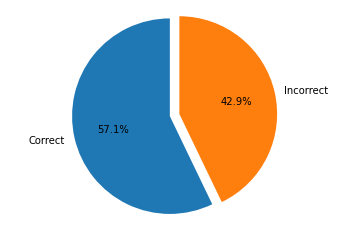

In [6]:
#visualise amount of correct predictions vs incorrect predictions

correct = 0
incorrect = 0

for i in range(0, len(predDf)):
    if predDf['ogSentiment'].iloc[i] == predDf['predSentiment'].iloc[i]:
        correct += 1
    else:
        incorrect += 1
        
print("Correct predictions:", correct)
print("Incorrect predictions:", incorrect)

import matplotlib.pyplot as plt

labels = 'Correct', 'Incorrect'
sizes = [correct, incorrect]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal')

plt.show()


In [1]:
print("Predicted sentiment towards", df['text'][selectedIndex], "is", closeDF['sentiment'].iloc[-1])
print("Original sentiment towards", df['text'][selectedIndex], "is", df['sentiment'][selectedIndex])

NameError: name 'df' is not defined